# GEONE - Gaussian Random Fields (GRF) based on FFT - Examples in 2D

Generate gaussian random fields (GRF) following a method based on (block) circulant embedding of the covariance matrix and Fast Fourier Transform (FFT) (to compute discrete Fourier Transform): functions `geone.grf.grf<d>D` and `geone.grf.krige<d>D`.

### References

- J\. W\. Cooley, J\. W\. Tukey (1965) An algorithm for machine calculation of complex Fourier series. Mathematics of Computation 19(90):297-301, [doi:10.2307/2003354](https://dx.doi.org/10.2307/2003354)
- C\. R\. Dietrich, G. N. Newsam (1993) A fast and exact method for multidimensional gaussian stochastic simulations. Water Resources Research 29(8):2861-2869, [doi:10.1029/93WR01070](https://dx.doi.org/10.1029/93WR01070)
- A\. T\. A\. Wood, G. Chan (1994) Simulation of Stationary Gaussian Processes in :math:`[0, 1]^d`. Journal of Computational and Graphical Statistics 3(4):409-432, [doi:10.2307/1390903](https://dx.doi.org/10.2307/1390903)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


## Covariance model in 2D: class `geone.covModel.covModel2D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

An azimuth angle, `alpha`, can be specified in degrees: the coordinates system Ox'y' supporting the axes of the model (ranges) is obtained from the original coordinates system Oxy by applying a rotation of `-alpha` (i.e. clockwise for positive angle).

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

In [3]:
cov_model = gn.covModel.CovModel2D(elem=[
    ('spherical', {'w':5., 'r':[150, 40]}), # elementary contribution
    ('nugget', {'w':.5})                    # elementary contribution
    ], alpha=-30, name='model-2D example')

In [4]:
cov_model

*** CovModel2D object ***
name = 'model-2D example'
number of elementary contribution(s): 2
elementary contribution 0
    type: spherical
    parameters:
        w = 5.0
        r = [150, 40]
elementary contribution 1
    type: nugget
    parameters:
        w = 0.5
angle: alpha = -30 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

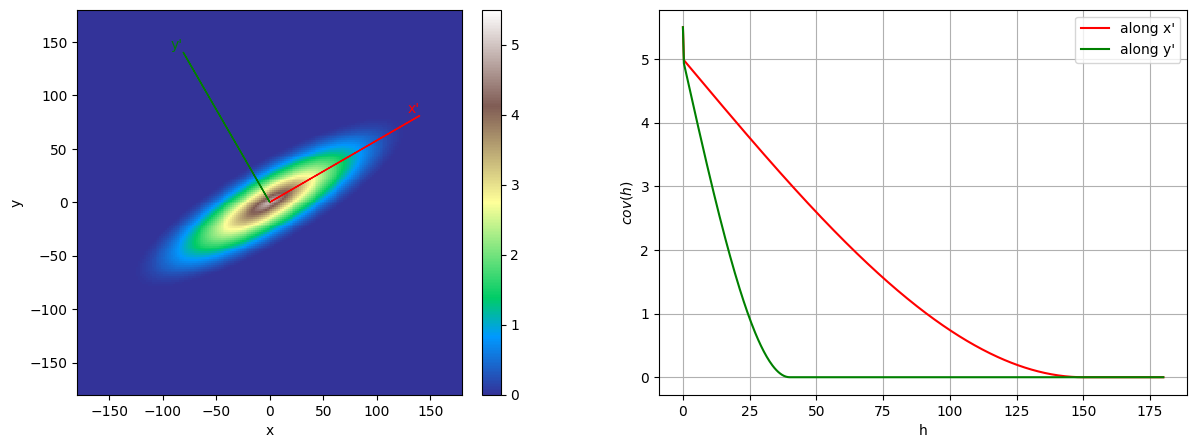

In [5]:
cov_model.plot_model(figsize=(15,5))
plt.suptitle('')
plt.show()

## GRFs - simulation and estimation in 2D
The following functions are used:

- `geone.grf.grf2D` for simulation 2D
- `geone.grf.krige2D` for estimation 2D

The algorithms are based on Fast Fourier Transform (FFT), then periodic fields are generated (for simulation / estimation). Hence, an extended simulation grid is used and then cropped after the simulation. The extension should be large enough in order to avoid wrong correlations, i.e. correlations across opposite borders of the grid, or correlations between two nodes regarding both distances between them (with respect to the periodic grid).

An appropriate extension is automatically computed by the function `geone.grf.grf2D` based on the covariance model class passed as first argument. However, the minimal extension can be given explicitly with the keyword argument `extensionMin`.

Note that a covariance function can be passed as first argument (e.g. the function `cov_model.func()` instead of the class `cov_model`). In this situation, an appropriate minimal extension can be computed by the function `extension_min` for each axis (i.e. `[geone.grf.extension_min(r, n, s) for r, n, s in zip(cov_model.rxy(), (nx, ny), (sx, sy))]`), and then passed to the GRF simulator `geone.grf.grf2D` via the keyword argument `extensionMin`.

*Notes.*
When passing the covariance model class as first argument, the extension is computed based on the range of the covariance. If the results show artefacts or unexpected features (this can happen when using Gaussian covariance model), one may try to fix the problem by increasing the extension. To do so, a factor (greather than one) can be specified via the keyword argument `rangeFactorForExtensionMin`: the range will be multiplied by this factor before computing the extension.

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1`: only error(s) (if any), `verbose=2` (default): error(s) and warning(s) encountered, `verbose=3`: error(s) and warning(s) encountered, and additional information.

### Data aggregation in grid
As the simulation / estimation is done in a grid, the conditioning data are first aggregated in the grid cells, i.e. data points falling in the same grid cell are aggregated in one unique value at the cell centre, using the operation specified by the parameter (keyword argument) `aggregate_data_op`, a string that can be `'sgs'` (i.e. function `geone.covModel.sgs` is used, for simulation only), `'krige'` (i.e. function `geone.covModel.krige` is used, default for estimation), `'min'`, `'max'`, `'mean'` (i.e. function `numpy.<aggregate_data_op>` is used), etc. Furthermore, the parameter (keyword argument) `aggregate_data_op_kwargs` is a dictionary that contains keyword arguments passed to the operation specified by `aggregate_data_op`.

If `aggregate_data_op='krige'` or `aggregate_data_op='sgs'` is specified, a covariance model (not directly a covariance function) has to be passed as first argument. 

*Note:* for simulation, by specifiying `aggregate_data_op='sgs'` (default), the aggregation is done for each realization (simulation), i.e. each simulation in the grid starts with a new set of values in conditioning grid cells.

### Alternative: wrapper `geone.multiGaussian.multiGaussianRun`

The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments:

- `mode='simulation', algo='fft'`: wrapper for `geone.grf.grf<d>D`
- `mode='estimation', algo='fft'`: wrapper for `geone.grf.krige<d>D`

where the dimension `<d>` is automatically detected. Note also that the function `geone.multiGaussian.multiGaussianRun` allows to choose the "format" of the output by the keyword argument `output_mode`:

- `output_mode='array'`: an numpy array is returned
- `output_mode='img'`: an "image" (class `geone.img.Img`) is returned

## GRFs - 2D
Define the simulation grid.

In [6]:
nx, ny = 220, 230  # number of cells
sx, sy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (sx, sy)
origin = (ox, oy)

## Case A - Unconditional 

### Simulation - case A
Set the number of realizations, the seed and launch the (unconditional) simulations.

In [7]:
nreal = 500
np.random.seed(123)
t1 = time.time() # start time
sim2Da = gn.grf.grf2D(cov_model, dimension, spacing, origin, nreal=nreal)
# sim2Da = gn.grf.grf2D(cov_model, dimension, spacing, origin, nreal=nreal, verbose=3)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 3.6 sec


In [8]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim2Da)}') # should be True

grf2D: Preliminary computation...
grf2D: Computing circulant embedding...
grf2D: embedding dimension: 512 x 512
grf2D: Computing FFT of circulant matrix...
Elapsed time: 3.3 sec
Same results ? True


The result is a 3d array of size `nreal` by `ny` by `nx`:

In [9]:
sim2Da.shape

(500, 230, 220)

Fill an image (`geone.img.Img` class) with all realizations (for display, see below), and delete the array sim2Da.

In [10]:
sim2Da_img = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=nreal, val=sim2Da)
del(sim2Da)

Compute the mean and the standard deviation over the realizations (pixel-wise).

In [11]:
sim2Da_mean_img = gn.img.imageContStat(sim2Da_img, op='mean') # pixel-wise mean
sim2Da_std_img = gn.img.imageContStat(sim2Da_img, op='std')   # pixel-wise standard deviation
# # Or:
# sim2Da_mean = np.mean(sim2Da, axis=0)
# sim2Da_std = np.std(sim2Da, axis=0)
# # and then fill new image with results

### Kriging - case A
Compute (simple) kriging estimates and standard deviation.

*Note: not really interesting here, without any data.*

In [12]:
t1 = time.time() # start time
krig2Da, krig2Da_std = gn.grf.krige2D(cov_model, dimension, spacing, origin)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill an image with two variables : kriging estimates and kriging std
krig2Da_img = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=2, val=np.array((krig2Da, krig2Da_std)))


Elapsed time: 0.0005 sec


In [13]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin,
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, np.array((krig2Da, krig2Da_std)))}') # should be True

Elapsed time: 0.0015 sec
Same results ? True


In [14]:
del(krig2Da, krig2Da_std)

### Plot results - case A

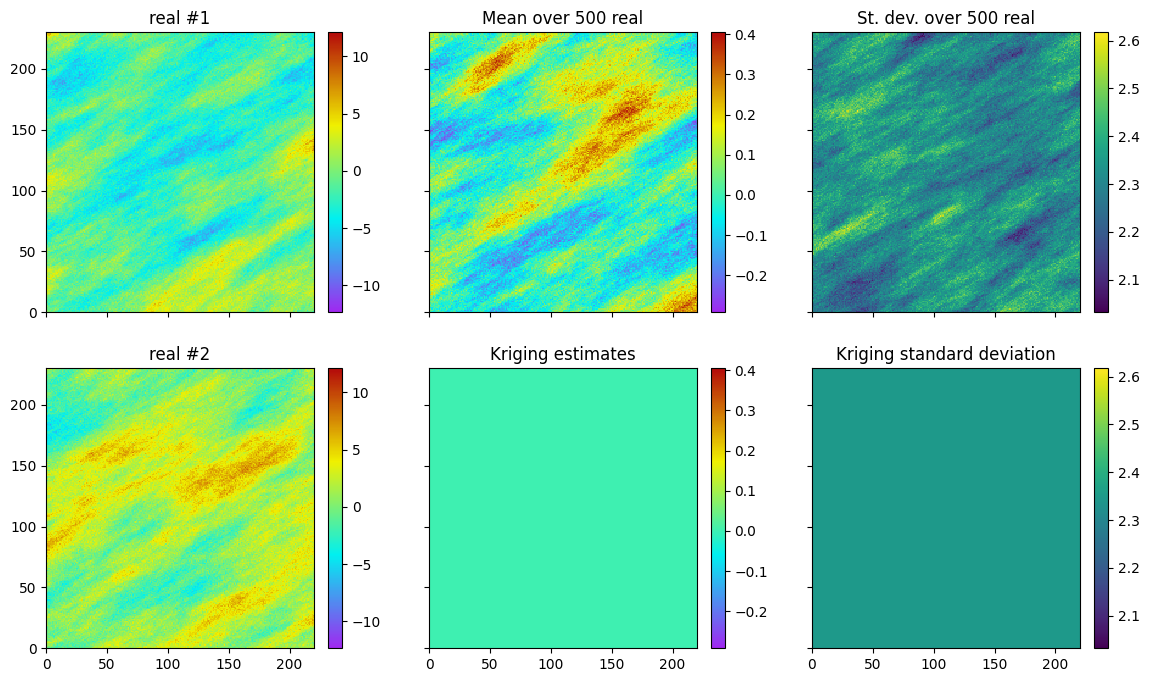

In [15]:
# Color settings
cmap = gn.customcolors.cmap1
vmin = sim2Da_img.val.min()
vmax = sim2Da_img.val.max()

cmap_mean = gn.customcolors.cmap1
vmin_mean = min(sim2Da_mean_img.val.min(), krig2Da_img.val[0].min())
vmax_mean = max(sim2Da_mean_img.val.max(), krig2Da_img.val[0].max())

cmap_std = 'viridis'
vmin_std = min(sim2Da_std_img.val.min(), krig2Da_img.val[1].min())
vmax_std = max(sim2Da_std_img.val.max(), krig2Da_img.val[1].max())

plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 3, 3*i+1)
    gn.imgplot.drawImage2D(sim2Da_img, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(f'real #{i+1}')

# mean of all real
plt.subplot(2, 3, 2)
gn.imgplot.drawImage2D(sim2Da_mean_img, cmap=cmap_mean, vmin=vmin_mean, vmax=vmax_mean)
plt.title(f'Mean over {nreal} real')

# standard deviation of all real
plt.subplot(2, 3, 3)
gn.imgplot.drawImage2D(sim2Da_std_img, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
plt.title(f'St. dev. over {nreal} real')

# kriging estimate
plt.subplot(2, 3, 5)
gn.imgplot.drawImage2D(krig2Da_img, iv=0, cmap=cmap_mean, vmin=vmin_mean, vmax=vmax_mean)
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(2, 3, 6)
gn.imgplot.drawImage2D(krig2Da_img, iv=1, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
plt.title('Kriging standard deviation')

plt.show()

### Comparison of mean and standard deviation of all realizations with kriging results - case A

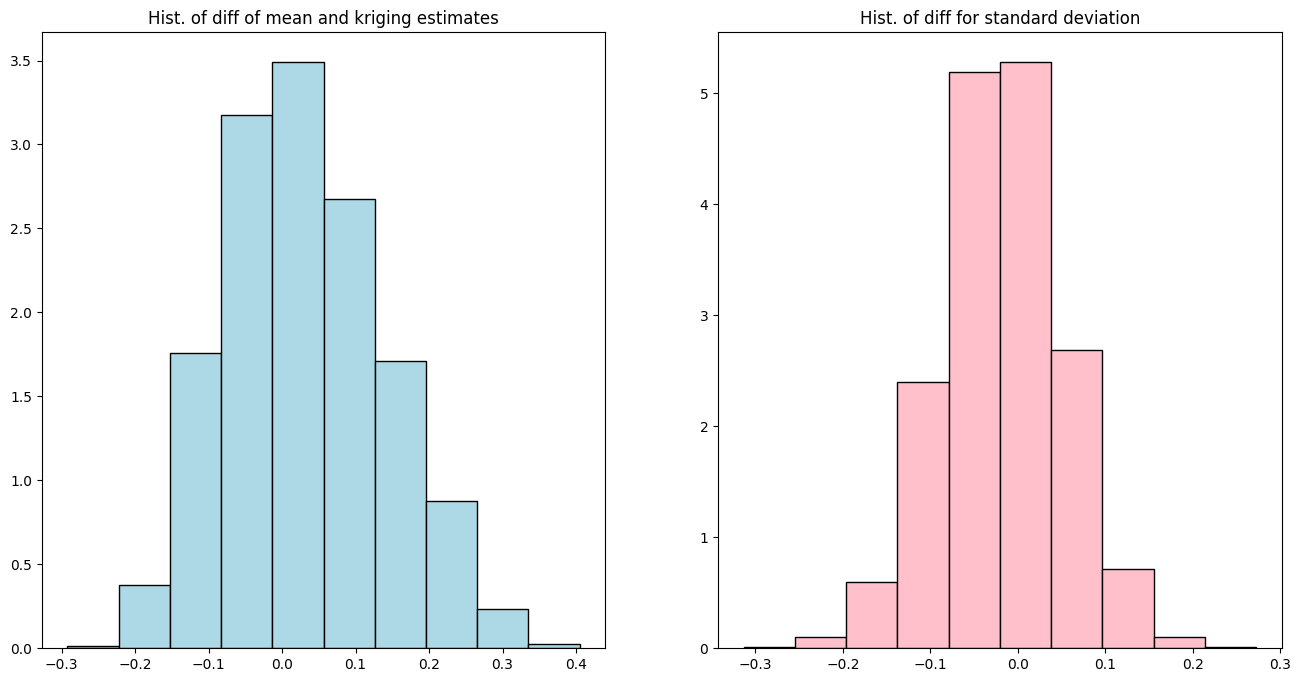

In [16]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(sim2Da_mean_img.val.reshape(-1) - krig2Da_img.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(sim2Da_std_img.val.reshape(-1) - krig2Da_img.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()

## Case B - Conditional
Define (hard) data.

In [17]:
# Data
x = np.array([[ 10.5 ,  20.5 ],  
              [ 50.82,  40.25],  
              [ 20.34, 150.95],  
              [200.52, 210.74]]) # data locations (real coordinates)
v = [ -3.,  2.,   5.,  -1.]  # data values


### Simulation - case B
Set the number of realizations, the seed and launch the simulations.

In [18]:
nreal = 500
np.random.seed(123)
t1 = time.time() # start time
sim2Db = gn.grf.grf2D(cov_model, dimension, spacing, origin, x=x, v=v, nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill image with result, and compute statistics
sim2Db_img = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=nreal, val=sim2Db)
del(sim2Db)
sim2Db_mean_img = gn.img.imageContStat(sim2Db_img, op='mean') # pixel-wise mean
sim2Db_std_img = gn.img.imageContStat(sim2Db_img, op='std')   # pixel-wise standard deviation

Elapsed time: 6.4 sec


In [19]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        x=x, v=v,
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim2Db_img.val[:, 0, :, :])}') # should be True

grf2D: Preliminary computation...
grf2D: Computing circulant embedding...
grf2D: embedding dimension: 512 x 512
grf2D: Computing FFT of circulant matrix...
grf2D: Treatment of conditioning data...
grf2D: Computing covariance matrix (rAA) for conditioning locations...
grf2D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 8.7 sec
Same results ? True


### Kriging - case B
Compute (simple) kriging estimates and standard deviation.

In [20]:
t1 = time.time() # start time
krig2Db, krig2Db_std = gn.grf.krige2D(cov_model, dimension, spacing, origin, x=x, v=v)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill an image with two variables : kriging estimates and kriging std
krig2Db_img = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=2, val=np.array((krig2Db, krig2Db_std)))
del(krig2Db, krig2Db_std)


Elapsed time: 0.075 sec


In [21]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin,
                                        x=x, v=v,
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, krig2Db_img.val[:, 0, :, :])}') # should be True

krige2D: Computing circulant embedding...
krige2D: embedding dimension: 512 x 512
krige2D: Computing FFT of circulant matrix...
krige2D: Computing covariance matrix (rAA) for conditioning locations...
krige2D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige2D: Computing rBA * rAA^(-1)...
krige2D: computing kriging estimates...
krige2D: computing kriging standard deviation ...
Elapsed time: 0.069 sec
Same results ? True


### Plot results - case B

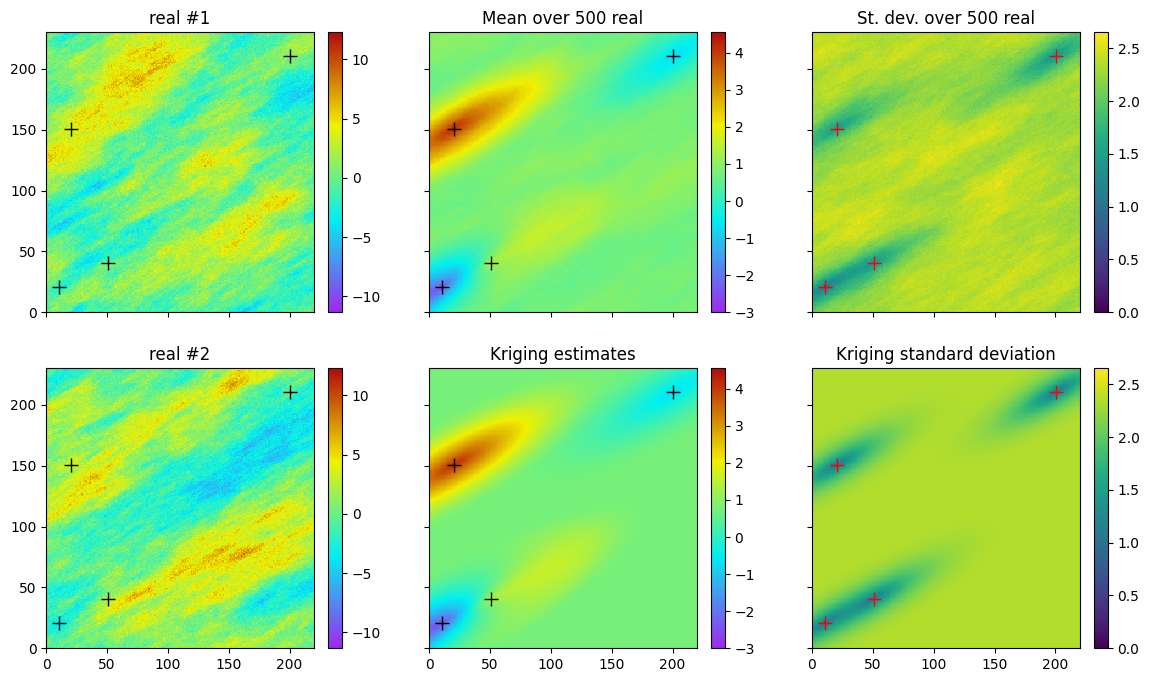

In [22]:
cmap = gn.customcolors.cmap1
vmin = sim2Db_img.val.min()
vmax = sim2Db_img.val.max()

cmap_mean = gn.customcolors.cmap1
vmin_mean = min(sim2Db_mean_img.val.min(), krig2Db_img.val[0].min())
vmax_mean = max(sim2Db_mean_img.val.max(), krig2Db_img.val[0].max())

cmap_std = 'viridis'
vmin_std = min(sim2Db_std_img.val.min(), krig2Db_img.val[1].min())
vmax_std = max(sim2Db_std_img.val.max(), krig2Db_img.val[1].max())

plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 3, 3*i+1)
    gn.imgplot.drawImage2D(sim2Db_img, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title(f'real #{i+1}')

# mean of all real
plt.subplot(2, 3, 2)
gn.imgplot.drawImage2D(sim2Db_mean_img, cmap=cmap_mean, vmin=vmin_mean, vmax=vmax_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title(f'Mean over {nreal} real')

# standard deviation of all real
plt.subplot(2, 3, 3)
gn.imgplot.drawImage2D(sim2Db_std_img, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=10) # add conditioning point locations
plt.title(f'St. dev. over {nreal} real')

# kriging estimate
plt.subplot(2, 3, 5)
gn.imgplot.drawImage2D(krig2Db_img, iv=0, cmap=cmap_mean, vmin=vmin_mean, vmax=vmax_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(2, 3, 6)
gn.imgplot.drawImage2D(krig2Db_img, iv=1, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=10) # add conditioning point locations
plt.title('Kriging standard deviation')

plt.show()

### Comparison of mean and standard deviation of all realizations with kriging results - case B

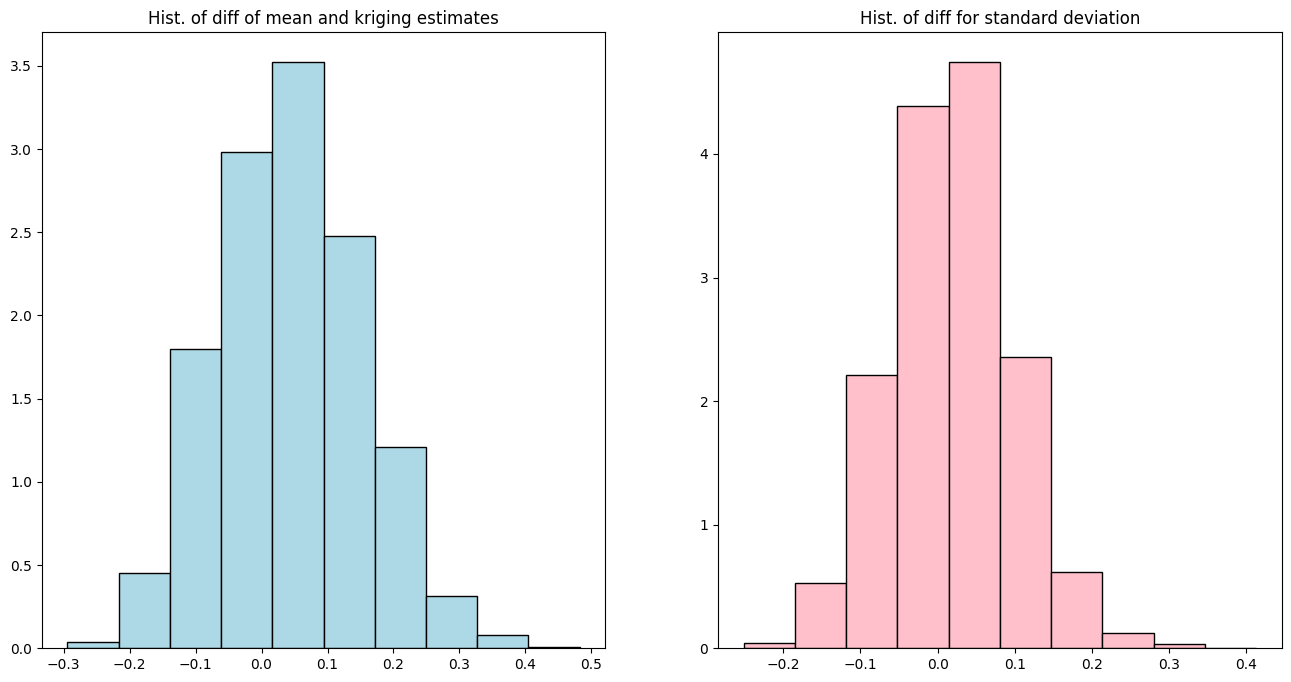

In [23]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(sim2Db_mean_img.val.reshape(-1) - krig2Db_img.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(sim2Db_std_img.val.reshape(-1) - krig2Db_img.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()

## Imposing mean and/or variance
Mean and variance in the simulation grid can be specified, they can be stationary (constant) or non-stationary. 
By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).



## Case C - Constant mean and variance
Set mean to $3.0$ and variance to the double of the covariance model sill. (Use the same data as above.)

### Simulation - case C
Set the number of realizations, the seed and launch the simulations.

In [24]:
nreal = 500
np.random.seed(123)
t1 = time.time() # start time
sim2Dc = gn.grf.grf2D(cov_model, dimension, spacing, origin, x=x, v=v, 
                      mean=3., var=2*cov_model.sill(), nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill image with result, and compute statistics
sim2Dc_img = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=nreal, val=sim2Dc)
del(sim2Dc)
sim2Dc_mean_img = gn.img.imageContStat(sim2Dc_img, op='mean') # pixel-wise mean
sim2Dc_std_img = gn.img.imageContStat(sim2Dc_img, op='std')   # pixel-wise standard deviation

Elapsed time: 7 sec


In [25]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        x=x, v=v,
                                        mean=3., var=2*cov_model.sill(),
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim2Dc_img.val[:, 0, :, :])}') # should be True

grf2D: Preliminary computation...
grf2D: Computing circulant embedding...
grf2D: embedding dimension: 512 x 512
grf2D: Computing FFT of circulant matrix...
grf2D: Treatment of conditioning data...
grf2D: Computing covariance matrix (rAA) for conditioning locations...
grf2D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 8.2 sec
Same results ? True


### Kriging - case C
Compute (simple) kriging estimates and standard deviation.

In [26]:
t1 = time.time() # start time
krig2Dc, krig2Dc_std = gn.grf.krige2D(cov_model, dimension, spacing, origin, x=x, v=v,
                                      mean=3., var=2*cov_model.sill())
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill an image with two variables : kriging estimates and kriging std
krig2Dc_img = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=2, val=np.array((krig2Dc, krig2Dc_std)))
del(krig2Dc, krig2Dc_std)


Elapsed time: 0.076 sec


In [27]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin,
                                        x=x, v=v,
                                        mean=3., var=2*cov_model.sill(),
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, krig2Dc_img.val[:, 0, :, :])}') # should be True

krige2D: Computing circulant embedding...
krige2D: embedding dimension: 512 x 512
krige2D: Computing FFT of circulant matrix...
krige2D: Computing covariance matrix (rAA) for conditioning locations...
krige2D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige2D: Computing rBA * rAA^(-1)...
krige2D: computing kriging estimates...
krige2D: computing kriging standard deviation ...
Elapsed time: 0.075 sec
Same results ? True


### Plot results - case C

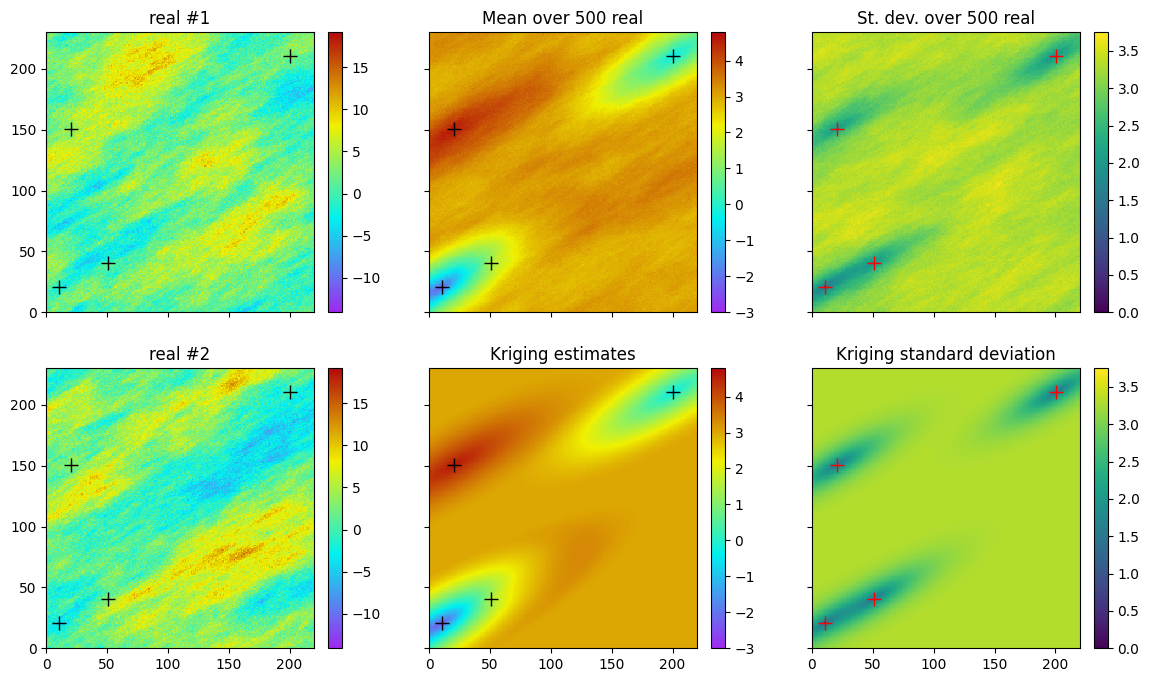

In [28]:
cmap = gn.customcolors.cmap1
vmin = sim2Dc_img.val.min()
vmax = sim2Dc_img.val.max()

cmap_mean = gn.customcolors.cmap1
vmin_mean = min(sim2Dc_mean_img.val.min(), krig2Dc_img.val[0].min())
vmax_mean = max(sim2Dc_mean_img.val.max(), krig2Dc_img.val[0].max())

cmap_std = 'viridis'
vmin_std = min(sim2Dc_std_img.val.min(), krig2Dc_img.val[1].min())
vmax_std = max(sim2Dc_std_img.val.max(), krig2Dc_img.val[1].max())

plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 3, 3*i+1)
    gn.imgplot.drawImage2D(sim2Dc_img, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title(f'real #{i+1}')

# mean of all real
plt.subplot(2, 3, 2)
gn.imgplot.drawImage2D(sim2Dc_mean_img, cmap=cmap_mean, vmin=vmin_mean, vmax=vmax_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title(f'Mean over {nreal} real')

# standard deviation of all real
plt.subplot(2, 3, 3)
gn.imgplot.drawImage2D(sim2Dc_std_img, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=10) # add conditioning point locations
plt.title(f'St. dev. over {nreal} real')

# kriging estimate
plt.subplot(2, 3, 5)
gn.imgplot.drawImage2D(krig2Dc_img, iv=0, cmap=cmap_mean, vmin=vmin_mean, vmax=vmax_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(2, 3, 6)
gn.imgplot.drawImage2D(krig2Dc_img, iv=1, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=10) # add conditioning point locations
plt.title('Kriging standard deviation')

plt.show()

### Comparison of mean and standard deviation of all realizations with kriging results - case C

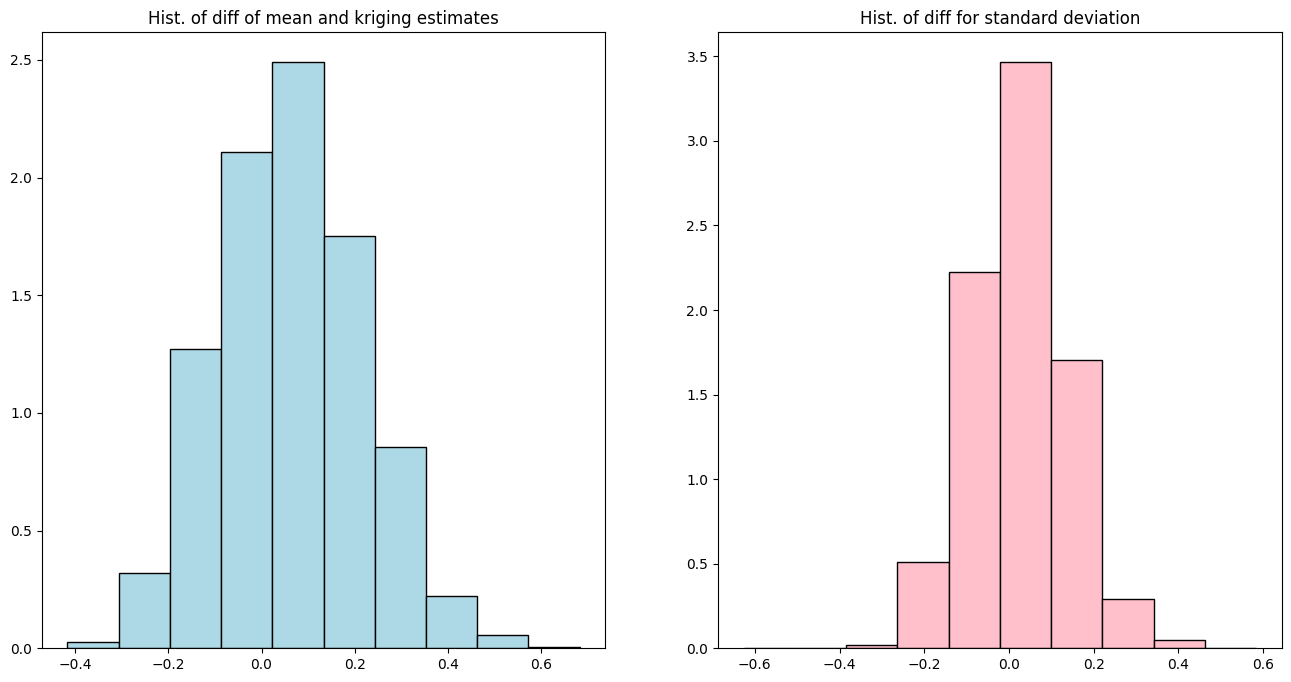

In [29]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(sim2Dc_mean_img.val.reshape(-1) - krig2Dc_img.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(sim2Dc_std_img.val.reshape(-1) - krig2Dc_img.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()


## Case D - Non-stationary mean and variance
Set a varying mean and a varying variance over the simulation domain.

In [30]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)

# Get the x and y coordinates of the centers of grid cell (meshgrid)
xx = im.xx()[0]
yy = im.yy()[0]

# Equivalent:
## xg, yg: coordinates of the centers of grid cell
#xg = ox + 0.5*sx + sx*np.arange(nx)
#yg = oy + 0.5*sy + sy*np.arange(ny)
#xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Define the mean and variance on the simulation grid
mean = 0.1*(yy - xx)         # define mean on the simulation grid
var = 1 + 0.1*(xx + yy)      # define variance on the simulation grid

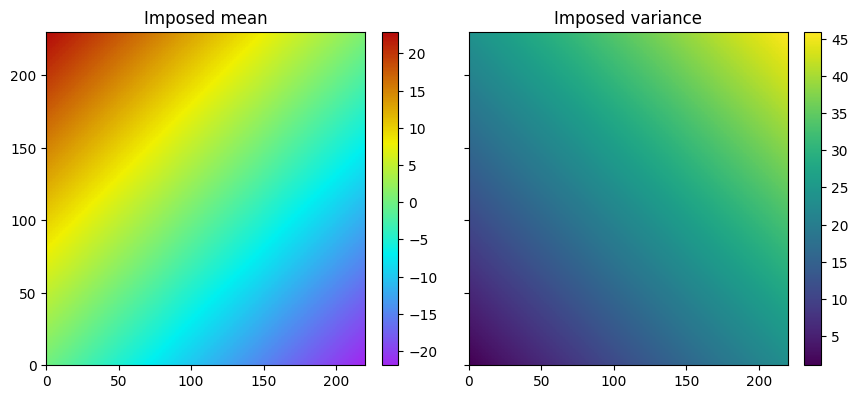

In [31]:

# Set variable mean and var in image im
im.append_var([mean, var], varname=['mean', 'var'])

# Display imposed mean and var
cmap = gn.customcolors.cmap1
cmap_std = 'viridis'

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

plt.subplot(1, 2, 1)
gn.imgplot.drawImage2D(im, iv=0, cmap=cmap)
plt.title('Imposed mean')

plt.subplot(1, 2, 2)
gn.imgplot.drawImage2D(im, iv=1, cmap=cmap_std)
plt.title('Imposed variance')

plt.show()

### Simulation - case D
Set the number of realizations, the seed and launch the simulations.

In [32]:
nreal = 500
np.random.seed(123)
t1 = time.time() # start time
sim2Dd = gn.grf.grf2D(cov_model, dimension, spacing, origin, x=x, v=v, 
                      mean=mean, var=var, nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill image with result, and compute statistics
sim2Dd_img = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=nreal, val=sim2Dd)
del(sim2Dd)
sim2Dd_mean_img = gn.img.imageContStat(sim2Dd_img, op='mean') # pixel-wise mean
sim2Dd_std_img = gn.img.imageContStat(sim2Dd_img, op='std')   # pixel-wise standard deviation

Elapsed time: 7.4 sec


In [33]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        x=x, v=v,
                                        mean=mean, var=var,
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim2Dd_img.val[:, 0, :, :])}') # should be True

grf2D: Preliminary computation...
grf2D: Computing circulant embedding...
grf2D: embedding dimension: 512 x 512
grf2D: Computing FFT of circulant matrix...
grf2D: Treatment of conditioning data...
grf2D: Computing covariance matrix (rAA) for conditioning locations...
grf2D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 9.2 sec
Same results ? True


### Kriging - case D
Compute (simple) kriging estimates and standard deviation.

In [34]:
t1 = time.time() # start time
krig2Dd, krig2Dd_std = gn.grf.krige2D(cov_model, dimension, spacing, origin, x=x, v=v,
                                      mean=mean, var=var)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill an image with two variables : kriging estimates and kriging std
krig2Dd_img = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=2, val=np.array((krig2Dd, krig2Dd_std)))
del(krig2Dd, krig2Dd_std)


Elapsed time: 0.073 sec


In [35]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin,
                                        x=x, v=v,
                                        mean=mean, var=var,
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, krig2Dd_img.val[:, 0, :, :])}') # should be True

krige2D: Computing circulant embedding...
krige2D: embedding dimension: 512 x 512
krige2D: Computing FFT of circulant matrix...
krige2D: Computing covariance matrix (rAA) for conditioning locations...
krige2D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige2D: Computing rBA * rAA^(-1)...
krige2D: computing kriging estimates...
krige2D: computing kriging standard deviation ...
Elapsed time: 0.076 sec
Same results ? True


### Plot results - case D

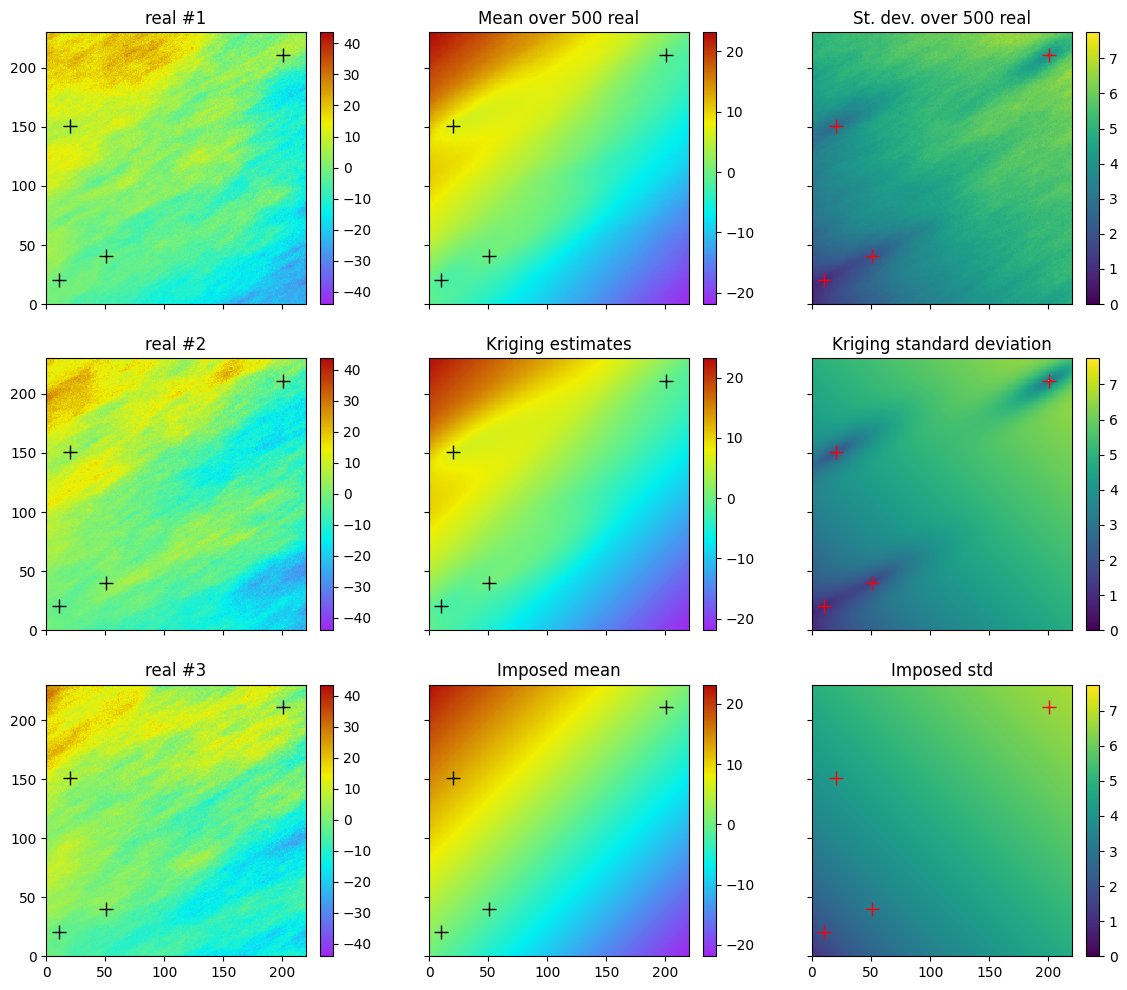

In [36]:
im_mean = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=1, val=im.val[0])
im_std = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=1, val=np.sqrt(im.val[1]))

cmap = gn.customcolors.cmap1
vmin = sim2Dd_img.val.min()
vmax = sim2Dd_img.val.max()

cmap_mean = gn.customcolors.cmap1
vmin_mean = min(sim2Dd_mean_img.val.min(), krig2Dd_img.val[0].min(), im_mean.val.min())
vmax_mean = max(sim2Dd_mean_img.val.max(), krig2Dd_img.val[0].max(), im_mean.val.max())

cmap_std = 'viridis'
vmin_std = min(sim2Dd_std_img.val.min(), krig2Dd_img.val[1].min(), im_std.val.min())
vmax_std = max(sim2Dd_std_img.val.max(), krig2Dd_img.val[1].max(), im_std.val.max())

plt.subplots(3, 3, figsize=(14, 12), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, 3*i+1)
    gn.imgplot.drawImage2D(sim2Dd_img, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title(f'real #{i+1}')

# mean of all real
plt.subplot(3, 3, 2)
gn.imgplot.drawImage2D(sim2Dd_mean_img, cmap=cmap_mean, vmin=vmin_mean, vmax=vmax_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title(f'Mean over {nreal} real')

# standard deviation of all real
plt.subplot(3, 3, 3)
gn.imgplot.drawImage2D(sim2Dd_std_img, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=10) # add conditioning point locations
plt.title(f'St. dev. over {nreal} real')

# kriging estimate
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(krig2Dd_img, iv=0, cmap=cmap_mean, vmin=vmin_mean, vmax=vmax_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(krig2Dd_img, iv=1, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=10) # add conditioning point locations
plt.title('Kriging standard deviation')

# Imposed mean
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_mean, cmap=cmap_mean, vmin=vmin_mean, vmax=vmax_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title(f'Imposed mean')

# Imposed std
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_std, cmap=cmap_std, vmin=vmin_std, vmax=vmax_std)
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=10) # add conditioning point locations
plt.title(f'Imposed std')

plt.show()

### Comparison of mean and standard deviation of all realizations with kriging results - case D

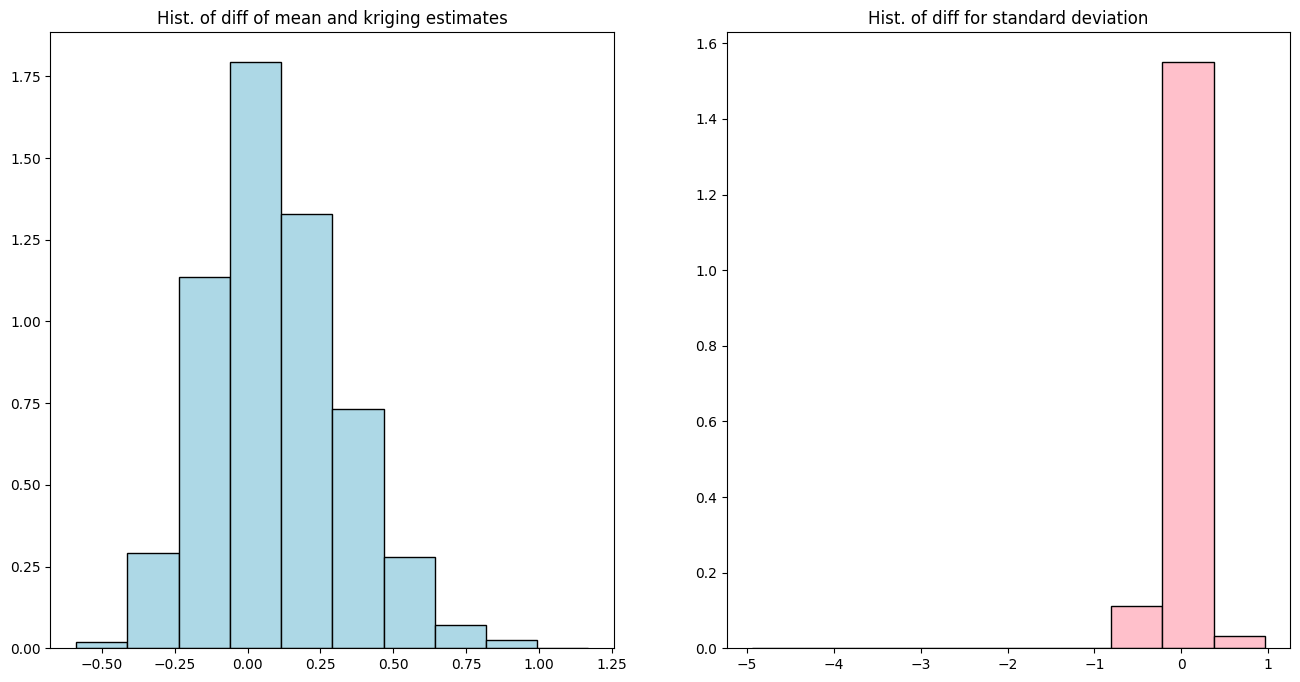

In [37]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(sim2Dd_mean_img.val.reshape(-1) - krig2Dd_img.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(sim2Dd_std_img.val.reshape(-1) - krig2Dd_img.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()